<a href="https://colab.research.google.com/github/cassidyhanna/DS-Unit-2-Kaggle-Challenge/blob/master/module1/U2%2CS2%2CM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 1*

---

# Decision Trees

## Assignment
- [ ] [Sign up for a Kaggle account](https://www.kaggle.com/), if you don’t already have one. Go to our Kaggle InClass competition website. You will be given the URL in Slack. Go to the Rules page. Accept the rules of the competition. Notice that the Rules page also has instructions for the Submission process. The Data page has feature definitions.
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Begin with baselines for classification.
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [0]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import category_encoders as ce
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import graphviz
from sklearn.tree import export_graphviz

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split the train into train & val 

train, val = train_test_split(train, train_size= 0.80, test_size = 0.20, 
                             stratify=train['status_group'], random_state = 42)

(train.shape,val.shape)

((47520, 41), (11880, 41))

In [0]:
sample_submission['status_group']

0        functional
1        functional
2        functional
3        functional
4        functional
            ...    
14353    functional
14354    functional
14355    functional
14356    functional
14357    functional
Name: status_group, Length: 14358, dtype: object

**Wrangle function** 

In [0]:
train[['longitude', 'latitude']].describe()

,longitude,latitude
count,47520.000000,4.752000e+04
mean,34.082431,-5.705946e+00
std,6.552053,2.941332e+00
min,0.000000,-1.164944e+01
25%,33.092142,-8.528215e+00
50%,34.910740,-5.021436e+00
75%,37.170578,-3.327185e+00
max,40.344301,-2.000000e-08


In [0]:
train

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
43360,72938,0.0,2011-07-27,NaN,0,NaN,33.542898,-9.174777,Kwa Mzee Noa,0,Lake Nyasa,Mpandapanda,Mbeya,12,4,Rungwe,Kiwira,0,True,GeoData Consultants Ltd,VWC,K,NaN,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
7263,65358,500.0,2011-03-23,Rc Church,2049,ACRA,34.665760,-9.308548,Kwa Yasinta Ng'Ande,0,Rufiji,Kitichi,Iringa,11,4,Njombe,Imalinyi,175,True,GeoData Consultants Ltd,WUA,Tove Mtwango gravity Scheme,True,2008,gravity,gravity,gravity,wua,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
2486,469,25.0,2011-03-07,Donor,290,Do,38.238568,-6.179919,Kwasungwini,0,Wami / Ruvu,Kwedigongo,Pwani,6,1,Bagamoyo,Mbwewe,2300,True,GeoData Consultants Ltd,VWC,NaN,False,2010,india mark ii,india mark ii,handpump,vwc,user-group,pay per bucket,per bucket,salty,salty,insufficient,insufficient,shallow well,shallow well,groundwater,hand pump,hand pump,functional
313,1298,0.0,2011-07-31,Government Of Tanzania,0,DWE,30.716727,-1.289055,Kwajovin 2,0,Lake Victoria,Kihanga,Kagera,18,1,Karagwe,Isingiro,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
52726,27001,0.0,2011-03-10,Water,0,Gove,35.389331,-6.399942,Chama,0,Internal,Mtakuj,Dodoma,1,6,Bahi,Nondwa,0,True,GeoData Consultants Ltd,VWC,Zeje,True,0,mono,mono,motorpump,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe,communal standpipe,functional
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9795,29534,50.0,2011-03-28,Wd And Id,489,WD and ID,38.268574,-5.450254,Kwa Maseko,4,Pangani,Komfungo A,Tanga,4,6,Handeni,Sindeni,1300,True,GeoData Consultants Ltd,VWC,WD and ID,False,2009,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,river,river/lake,surface,communal standpipe,communal standpipe,non functional
58170,20672,0.0,2011-12-07,Danida,0,Central government,33.926294,-9.641293,Kwa Asajile Mwangomale,0,Lake Nyasa,Mpanda,Mbeya,12,3,Kyela,Bujonde,0,True,GeoData Consultants Ltd,VWC,Ngana water supplied scheme,True,0,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,dry,dry,spring,spring,groundwater,communal standpipe,communal standpipe,non functional
17191,10282,0.0,2013-02-02,World Bank,599,Nandra Construction,39.262924,-10.768079,Shuleni,0,Ruvuma / Southern Coast,Kilimahewa,Mtwara,90,33,Newala,Mchemo,1,True,GeoData Consultants Ltd,VWC,Malatu Chini,False,2012,submersible,submersible,submersible,vwc,user-group,other,other,soft,good,enough,enough,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
8192,64193,30.0,2013-02-07,Finida German Tanzania Govt,426,Finwater,39.348550,-10.642069,Tangini,0,Ruvuma / Southern Coast,Tangini,Mtwara,90,33,Newala,Kitangari,320,True,GeoData Consultants Ltd,VWC,Mitema,False,1988,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,soft,good,insufficient,insufficient,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,functional


In [0]:
def wrangle(X):

  # prevent setting with copy warning
  X = X.copy()

  # treat latitude values that are near zero like zero
  X['latitude'] = (X['latitude'].replace(-2e-08,0))
  
  # When columns have zeros and shouldn't, they are like null values.
  # So we will replace the zeros with nulls, and impute missing value later.
  cols_with_zero = ['longitude','latitude']
  for col in cols_with_zero:
    X[col] = X[col].replace(0, np.nan)
  
  # quantity & quantity_group are duplicates, so drop one
  X = X.drop(columns=['basin','quantity_group','recorded_by','source_type','extraction_type_group','waterpoint_type','region','region_code'])
  
   #X['Functional'] = (X['status_group'] == 'functional').astype(int)
  # return the wrangled dataframe
  
  return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

**Do train/validate/test split with the Tanzania Waterpumps data**

**Select Features**

In [0]:
target = 'status_group'

train_features = train.drop(columns = [target, 'id'])

#get a list with the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

#get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

#get a list of all the categorical features with cardinality of 50 or less
categorical_features = cardinality[cardinality <= 15].index.tolist()

# Combine the list
features = numeric_features + categorical_features
print(len(features))
print(features)

22
['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'district_code', 'population', 'construction_year', 'public_meeting', 'scheme_management', 'permit', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_class', 'waterpoint_type_group']


**Selecting numeric features**

In [0]:
# Arrange data into X features and y target
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]




print(X_train.shape,y_train.shape,X_val.shape,y_val.shape, X_test.shape)

(47520, 22) (47520,) (11880, 22) (11880,) (14358, 22)


**Baseline**

In [0]:
train['status_group'].value_counts(normalize=True)

functional                 0.543077
non functional             0.384238
functional needs repair    0.072685
Name: status_group, dtype: float64

In [0]:
# if we guessed majority clsss for every prediction
# in this case our majority class is functional water pump
majority_class = y_train.mode()[0]
y_pred_baseline = [majority_class] * len(y_train)

In [0]:
# what is the baseline accuracy if we guessed majority class for every prediction
#test first with our our train set
accuracy_score(y_train, y_pred_baseline)

0.5430765993265994

In [0]:
#test accuracy score with validation set
majority_class = y_val.mode()[0]
y_pred_baseline = [majority_class] * len(y_val)
accuracy_score(y_val, y_pred_baseline)

0.5430976430976431

In [0]:
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy='median'),
    StandardScaler(),
    DecisionTreeClassifier(random_state = 42)
    )

pipeline.fit(X_train, y_train)

print('Training Accuracy:', pipeline.score(X_train, y_train))
print('Validation Accuracy:', pipeline.score(X_val,y_val))

Training Accuracy: 0.9946969696969697
Validation Accuracy: 0.7558922558922558


Since the Training score is almost perfect we may be overfitting the data

**Plot of Decision tree**

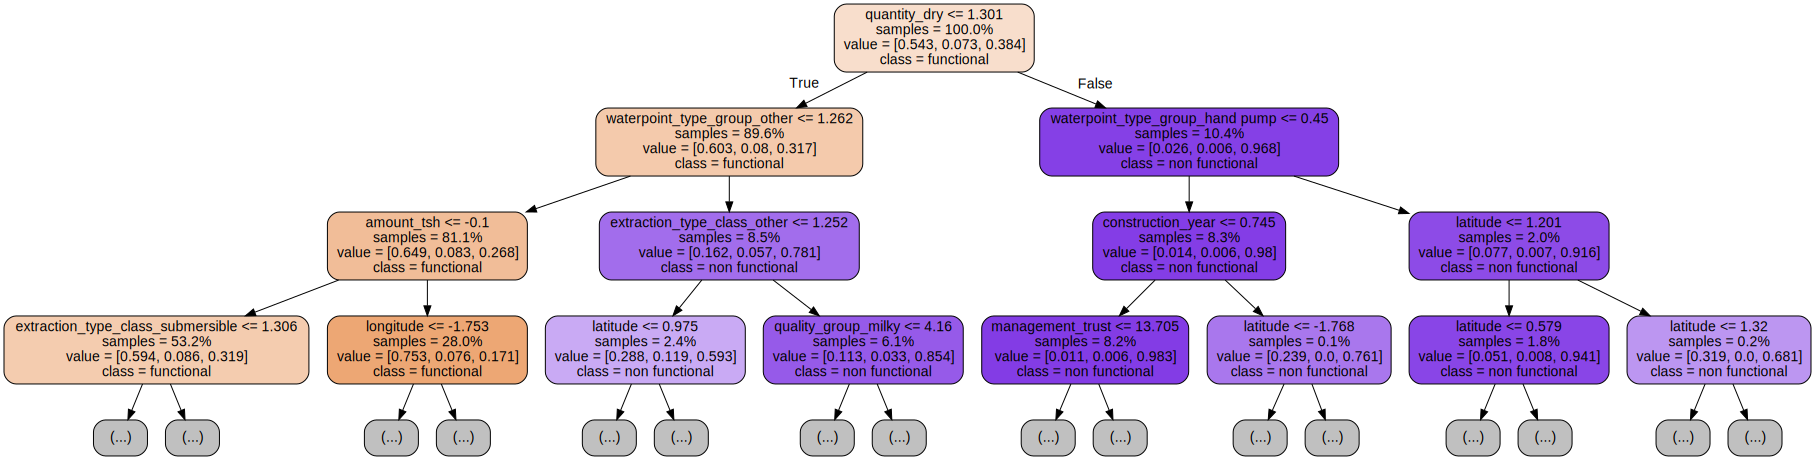

In [0]:
# DTC = decision tree classifier

model = pipeline.named_steps['decisiontreeclassifier']
encoder = pipeline.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

dot_data = export_graphviz(model,
                           out_file = None,
                           max_depth = 3,
                           feature_names =encoded_columns,
                           class_names=model.classes_,
                           impurity=False,
                           filled=True,
                           proportion=True,
                           rounded=True
                           )

display(graphviz.Source(dot_data))

Below we increased the min_samples_leaf which decreased the reducible error between the train and validation set.

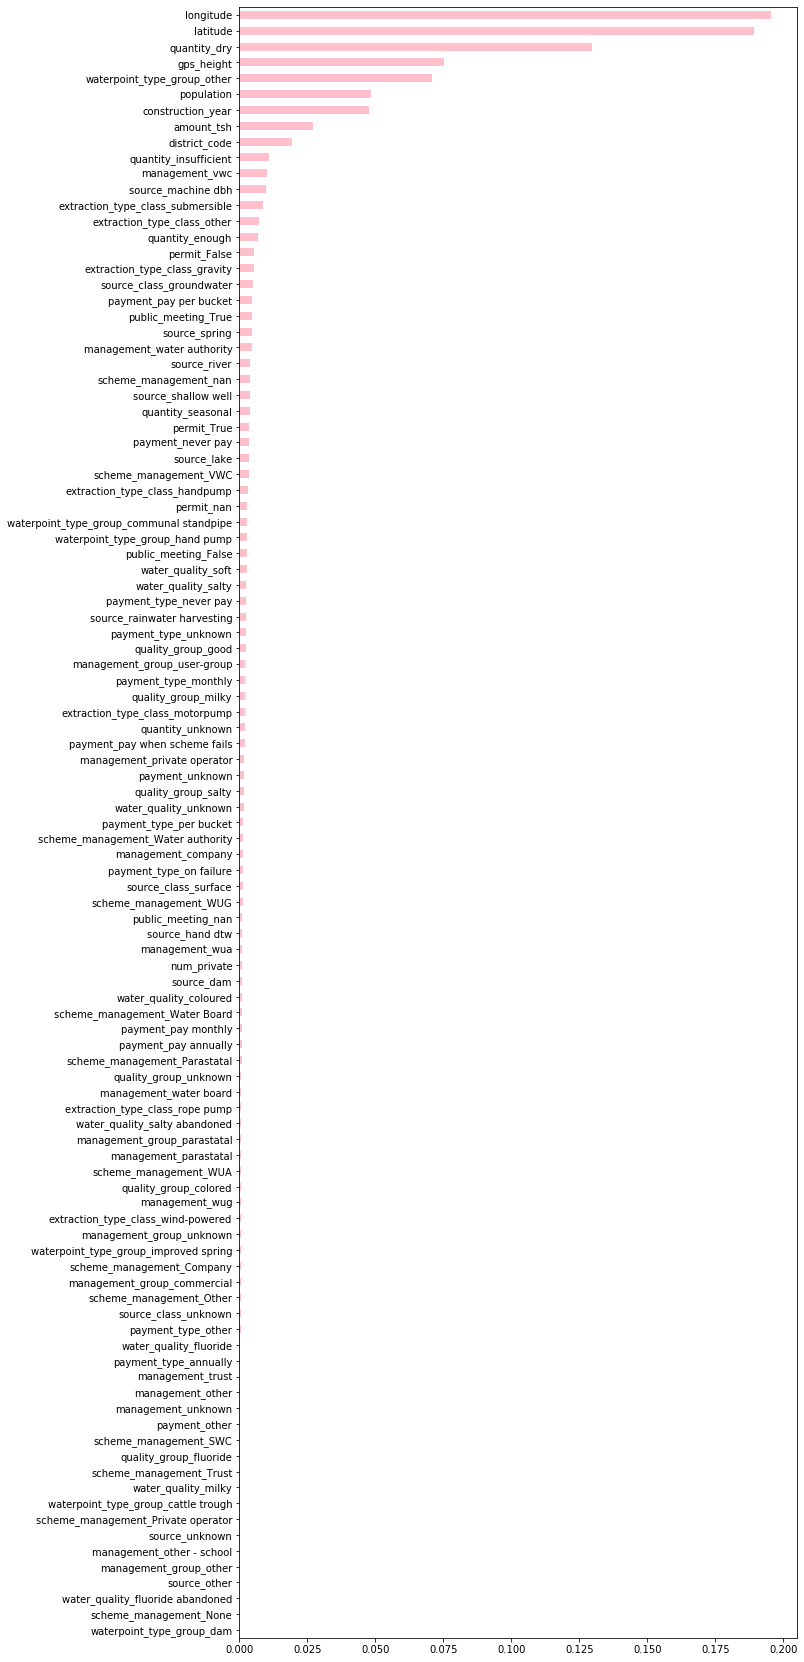

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

coefficients = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize = (10,30))
coefficients.sort_values().plot.barh(color = 'pink')

In [0]:
coefficients

amount_tsh                               0.027038
gps_height                               0.075116
longitude                                0.195372
latitude                                 0.189188
num_private                              0.001022
                                           ...   
waterpoint_type_group_hand pump          0.002750
waterpoint_type_group_other              0.070715
waterpoint_type_group_improved spring    0.000560
waterpoint_type_group_cattle trough      0.000086
waterpoint_type_group_dam                0.000000
Length: 103, dtype: float64

In [0]:
encoder = ce.OrdinalEncoder()
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)


X_train_imputer = imputer.fit_transform(X_train_encoded)
X_val_imputer = imputer.transform(X_val_encoded)
X_test_imputer = imputer.transform(X_test_encoded)


X_train_scaler = scaler.fit_transform(X_train_imputer)
X_val_scaler = scaler.transform(X_val_imputer)
X_test_scaler = scaler.transform(X_test_imputer)

In [0]:
pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(max_depth=10,  min_samples_leaf=15, random_state=42)
)
#fit training set
pipeline.fit(X_train_encoded,y_train)
#scores
print('Training score', pipeline.score(X_train_encoded,y_train))
print('Validation score', pipeline.score(X_val_encoded , y_val))

Training score 0.7572390572390573
Validation score 0.7427609427609427


In [0]:
pipeline1 = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler(),
    LogisticRegression(random_state=42, solver = 'lbfgs', max_iter= 200)
)
#fit training set
pipeline.fit(X_train_encoded,y_train)
#scores
print('Training score', pipeline.score(X_train_encoded,y_train))
print('Validation score', pipeline.score(X_val_encoded , y_val))

Training score 0.7572390572390573
Validation score 0.7427609427609427


In [0]:
pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(min_samples_leaf=6, random_state=42),
)
#fit training set
pipeline.fit(X_train_encoded,y_train)
#scores
print('Training score', pipeline.score(X_train_encoded,y_train))
print('Validation score', pipeline.score(X_val_encoded , y_val))

Training score 0.8636574074074074
Validation score 0.7737373737373737


In [0]:
pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    DecisionTreeClassifier(min_samples_leaf=10, random_state=42)
)
#fit training set
pipeline.fit(X_train_encoded,y_train)
#scores
print('Training score', pipeline.score(X_train_encoded,y_train))
print('Validation score', pipeline.score(X_val_encoded , y_val))

Training score 0.8372053872053872
Validation score 0.7746632996632996


In [0]:
pd.Series([coefficients[coefficients < 0.05].index])

0    Index(['amount_tsh', 'num_private', 'district_...
dtype: object

In [0]:
X_train_encoded.drop(columns= drop_columns)
X_val_encoded.drop(columns= drop_columns)
X_test_encode.drop(columns= drop_columns)


NameError: ignored

In [0]:
features = coefficients[coefficients<0.001].index



In [0]:
y_pred = pipeline.predict(X_test_imputer)
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission_8.csv', index = False)